# `CNModel` Hyperfine Anomalies

Trey V. Wenger (c) March 2025

`CNModel` can also account for a full physical treatment of non-LTE effects. That is, it can model situations where the excitation temperature is *not* the same for each transition. `CNModel` considers the detailed balance between all transitions in the `mol_data` dictionary. For ${\rm CN}$ this includes all of the $N=1-0$ ($\nu = 0$) hyperfine transitions at 113.15 and 113.5 GHz, and for $^{13}{\rm CN}$ this includes all of the $N=1-0$ hyperfine transitions at 108.06 GHz, 108.4 GHz, 108.6 GHz, 108.8 GHz, and 109.2 GHz. Each state column density is a free parameter, and the relative state column densities are set by the excitation temperature. Since there are more transitions than states, this is an overconstrained problem and easy for a Bayesian forward model to solve.

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("arviz version:", az.__version__)

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

arviz version: 0.22.0dev
pymc version: 5.21.1
bayes_spec version: 1.7.5
bayes_cn_hfs version: 1.1.1+9.gf278c50.dirty


## Simulate data

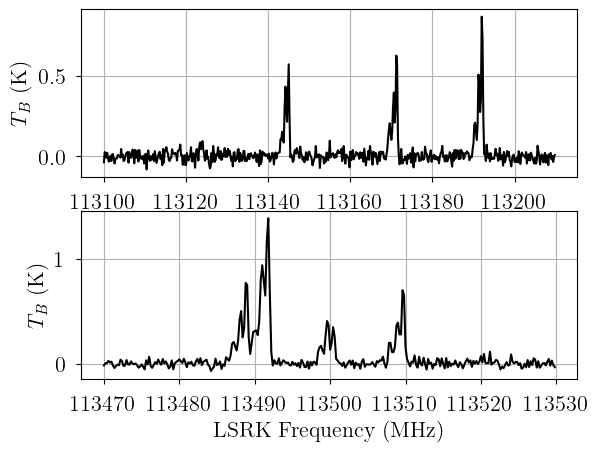

In [2]:
from bayes_cn_hfs import supplement_mol_data
from bayes_spec import SpecData
from bayes_cn_hfs.cn_model import CNModel

mol_data_12CN, mol_weight_12CN = supplement_mol_data("CN")

# spectral axis definition
freq_axis_1 = np.arange(113100.0, 113210.0, 0.2) # MHz
freq_axis_2 = np.arange(113470.0, 113530.0, 0.2) # MHz

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.03 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data_1 = noise * np.random.randn(len(freq_axis_1)) # K
brightness_data_2 = noise * np.random.randn(len(freq_axis_2)) # K

# CNModel datasets can be named anything, here we name them "12CN-1" and "12CN-2"
obs_1 = SpecData(
    freq_axis_1,
    brightness_data_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
obs_2 = SpecData(
    freq_axis_2,
    brightness_data_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
dummy_data = {"12CN-1": obs_1, "12CN-2": obs_2}

# Initialize and define the model
n_clouds = 3 # number of cloud components
baseline_degree = 0 # polynomial baseline degree
model = CNModel(
    dummy_data,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [13.5, 1.0], # mean and width of log10 total column density prior (cm-2)
    prior_log10_Tkin = [1.0, 0.5], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = None, # assume Gaussian line profile
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log10_Tex = [0.5, 0.1], # mean and width of log10 excitation temperature prior (K)
    assume_CTEX = False, # do not assume CTEX
    prior_LTE_precision = 100.0, # width of LTE precision prior
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

sim_params = {
    "log10_N": [13.8, 13.9, 14.0],
    "log10_Tkin": [0.65, 0.6, 0.5],
    "fwhm_nonthermal": [1.0, 1.25, 1.5],
    "velocity": [-2.0, 0.0, 2.5],
    "fwhm_L": 0.0,
    "log10_Tex_ul": [0.65, 0.6, 0.5],
    "LTE_precision": [1.0e-3, 1.0e-4, 1.0e-5],
    "baseline_12CN-1_norm": [0.0],
    "baseline_12CN-2_norm": [0.0],
}

# add derived quantities to sim_params
for key in model.cloud_deterministics:
    if key not in sim_params.keys():
        sim_params[key] = model.model[key].eval(sim_params, on_unused_input="ignore")

# Evaluate and save simulated observations
sim_obs1 = model.model["12CN-1"].eval(sim_params, on_unused_input="ignore")
sim_obs2 = model.model["12CN-2"].eval(sim_params, on_unused_input="ignore")

# Plot the simulated data
fig, axes = plt.subplots(2)
axes[0].plot(dummy_data["12CN-1"].spectral, sim_obs1, "k-")
axes[0].set_ylabel(dummy_data["12CN-1"].ylabel)
axes[1].plot(dummy_data["12CN-2"].spectral, sim_obs2, "k-")
axes[1].set_xlabel(dummy_data["12CN-2"].xlabel)
_ = axes[1].set_ylabel(dummy_data["12CN-2"].ylabel)

In [3]:
sim_params

{'log10_N': [13.8, 13.9, 14.0],
 'log10_Tkin': [0.65, 0.6, 0.5],
 'fwhm_nonthermal': [1.0, 1.25, 1.5],
 'velocity': [-2.0, 0.0, 2.5],
 'fwhm_L': 0.0,
 'log10_Tex_ul': [0.65, 0.6, 0.5],
 'LTE_precision': [0.001, 0.0001, 1e-05],
 'baseline_12CN-1_norm': [0.0],
 'baseline_12CN-2_norm': [0.0],
 'fwhm_thermal': array([0.08867757, 0.08371703, 0.07461288]),
 'fwhm': array([1.00392416, 1.25280028, 1.50185455]),
 'Tex': array([[4.07866031, 3.8581187 , 3.10765679],
        [4.45041102, 3.94669369, 3.11764063],
        [4.74113757, 3.86977462, 3.15693411],
        [5.25059693, 3.95885047, 3.16722314],
        [4.68685949, 3.83450162, 3.15866611],
        [4.81957089, 4.04743915, 3.16329061],
        [3.68273421, 3.80676127, 3.13964005],
        [5.18258261, 3.9216992 , 3.16893727],
        [3.98215475, 3.89268354, 3.14978974]]),
 'tau': array([[0.03044327, 0.04129563, 0.06385354],
        [0.21356188, 0.32412591, 0.51919299],
        [0.22552979, 0.32969246, 0.50749502],
        [0.24767854, 0.41

## Model Definition

We fix the kinetic temperature because we can't measure the thermal line width.

In [4]:
# Now we pack the simulated spectrum into a new SpecData instance
obs_1 = SpecData(
    freq_axis_1,
    sim_obs1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
obs_2 = SpecData(
    freq_axis_2,
    sim_obs2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
data = {"12CN-1": obs_1, "12CN-2": obs_2}

# Initialize and define the model
model = CNModel(
    data,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [13.5, 1.0], # mean and width of log10 total column density prior (cm-2)
    prior_log10_Tkin = [1.0, 0.5], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = None, # assume Gaussian line profile
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log10_Tex = [0.5, 0.1], # mean and width of log10 excitation temperature prior (K)
    assume_CTEX = False, # do not assume CTEX
    prior_LTE_precision = 100.0, # width of LTE precision prior
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Sampling: [12CN-1, 12CN-2, LTE_precision, baseline_12CN-1_norm, baseline_12CN-2_norm, fwhm_nonthermal_norm, log10_N_norm, log10_Tex_ul_norm, log10_Tkin_norm, velocity_norm, weights]


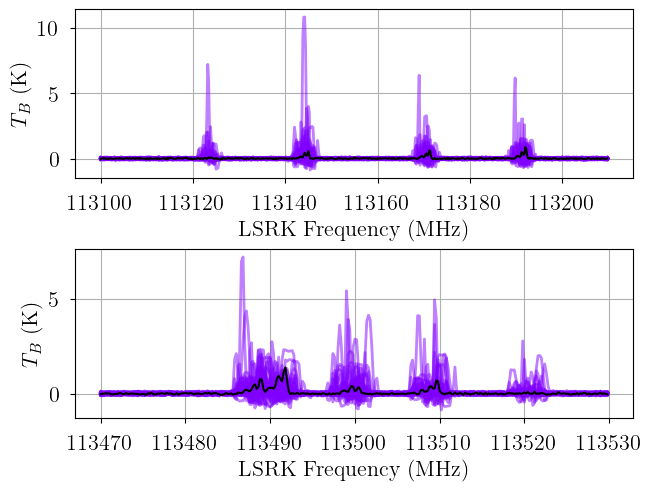

In [5]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

baseline_freeRVs ['baseline_12CN-1_norm', 'baseline_12CN-2_norm']
baseline_deterministics []
cloud_freeRVs ['velocity_norm', 'log10_Tkin_norm', 'fwhm_nonthermal_norm', 'log10_N_norm', 'log10_Tex_ul_norm', 'LTE_precision', 'weights']
cloud_deterministics ['velocity', 'log10_Tkin', 'fwhm_thermal', 'fwhm_nonthermal', 'fwhm', 'log10_N', 'log10_Tex_ul', 'Tex', 'tau', 'tau_total', 'TR']
hyper_freeRVs []
hyper_deterministics []


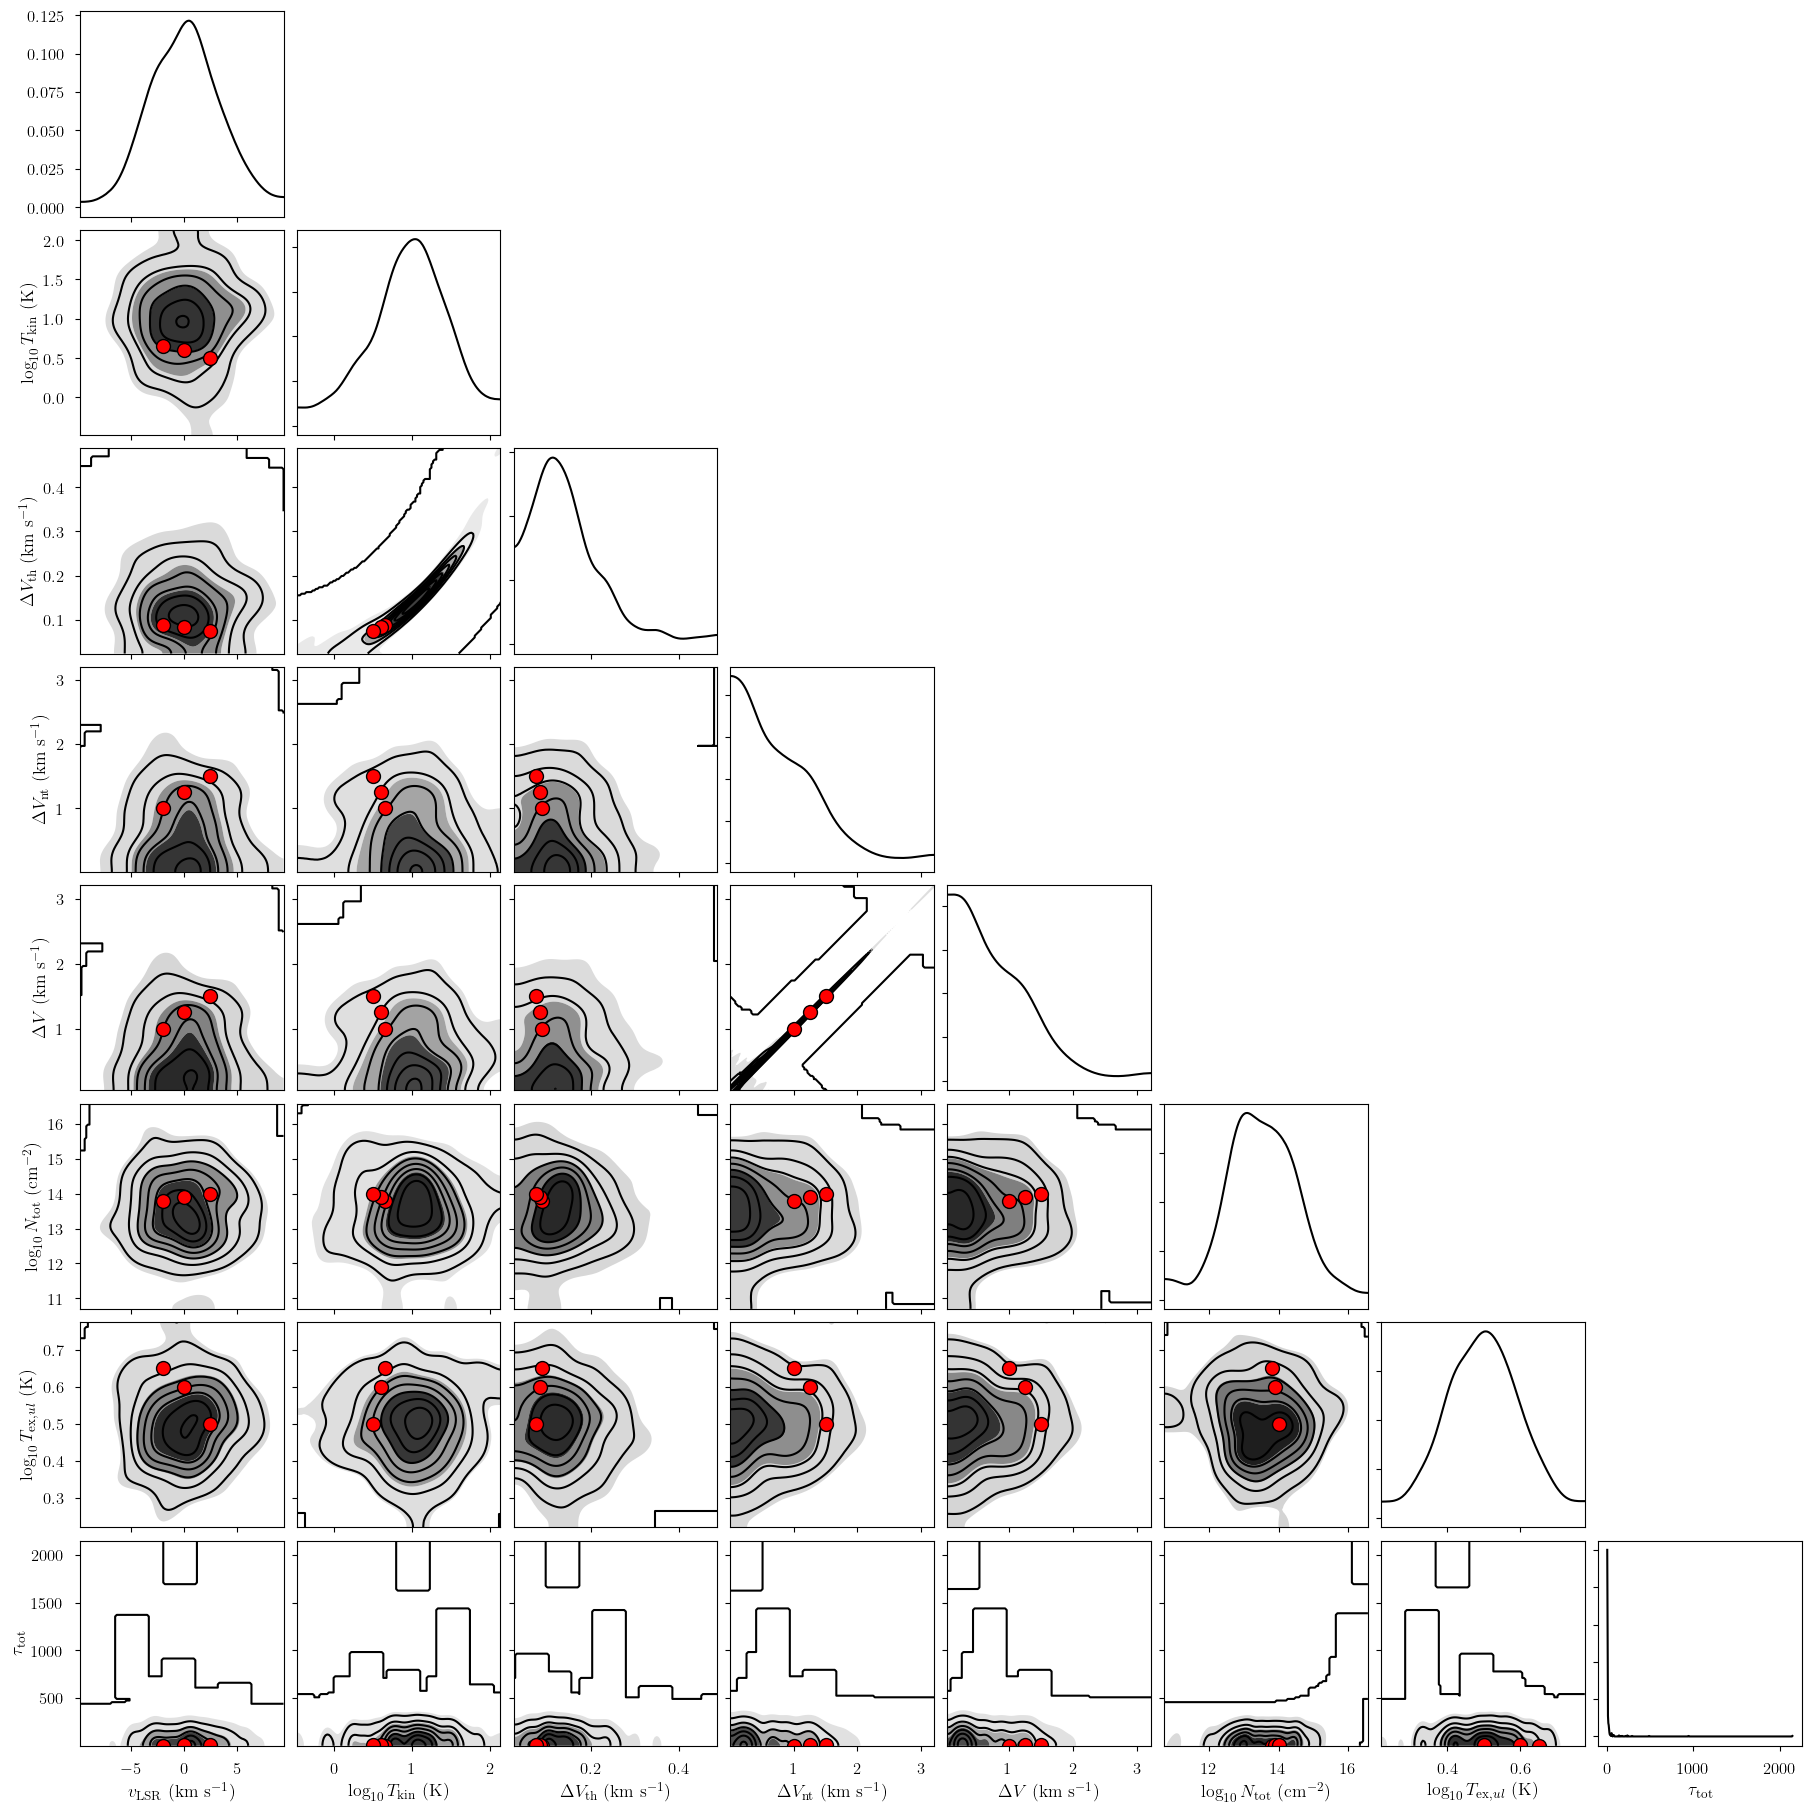

In [6]:
from bayes_spec.plots import plot_pair

# available parameter attributes:
print("baseline_freeRVs", model.baseline_freeRVs)
print("baseline_deterministics", model.baseline_deterministics)
print("cloud_freeRVs", model.cloud_freeRVs)
print("cloud_deterministics", model.cloud_deterministics)
print("hyper_freeRVs", model.hyper_freeRVs)
print("hyper_deterministics", model.hyper_deterministics)

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
_ = plot_pair(
    prior.prior, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=sim_params, # truths
)

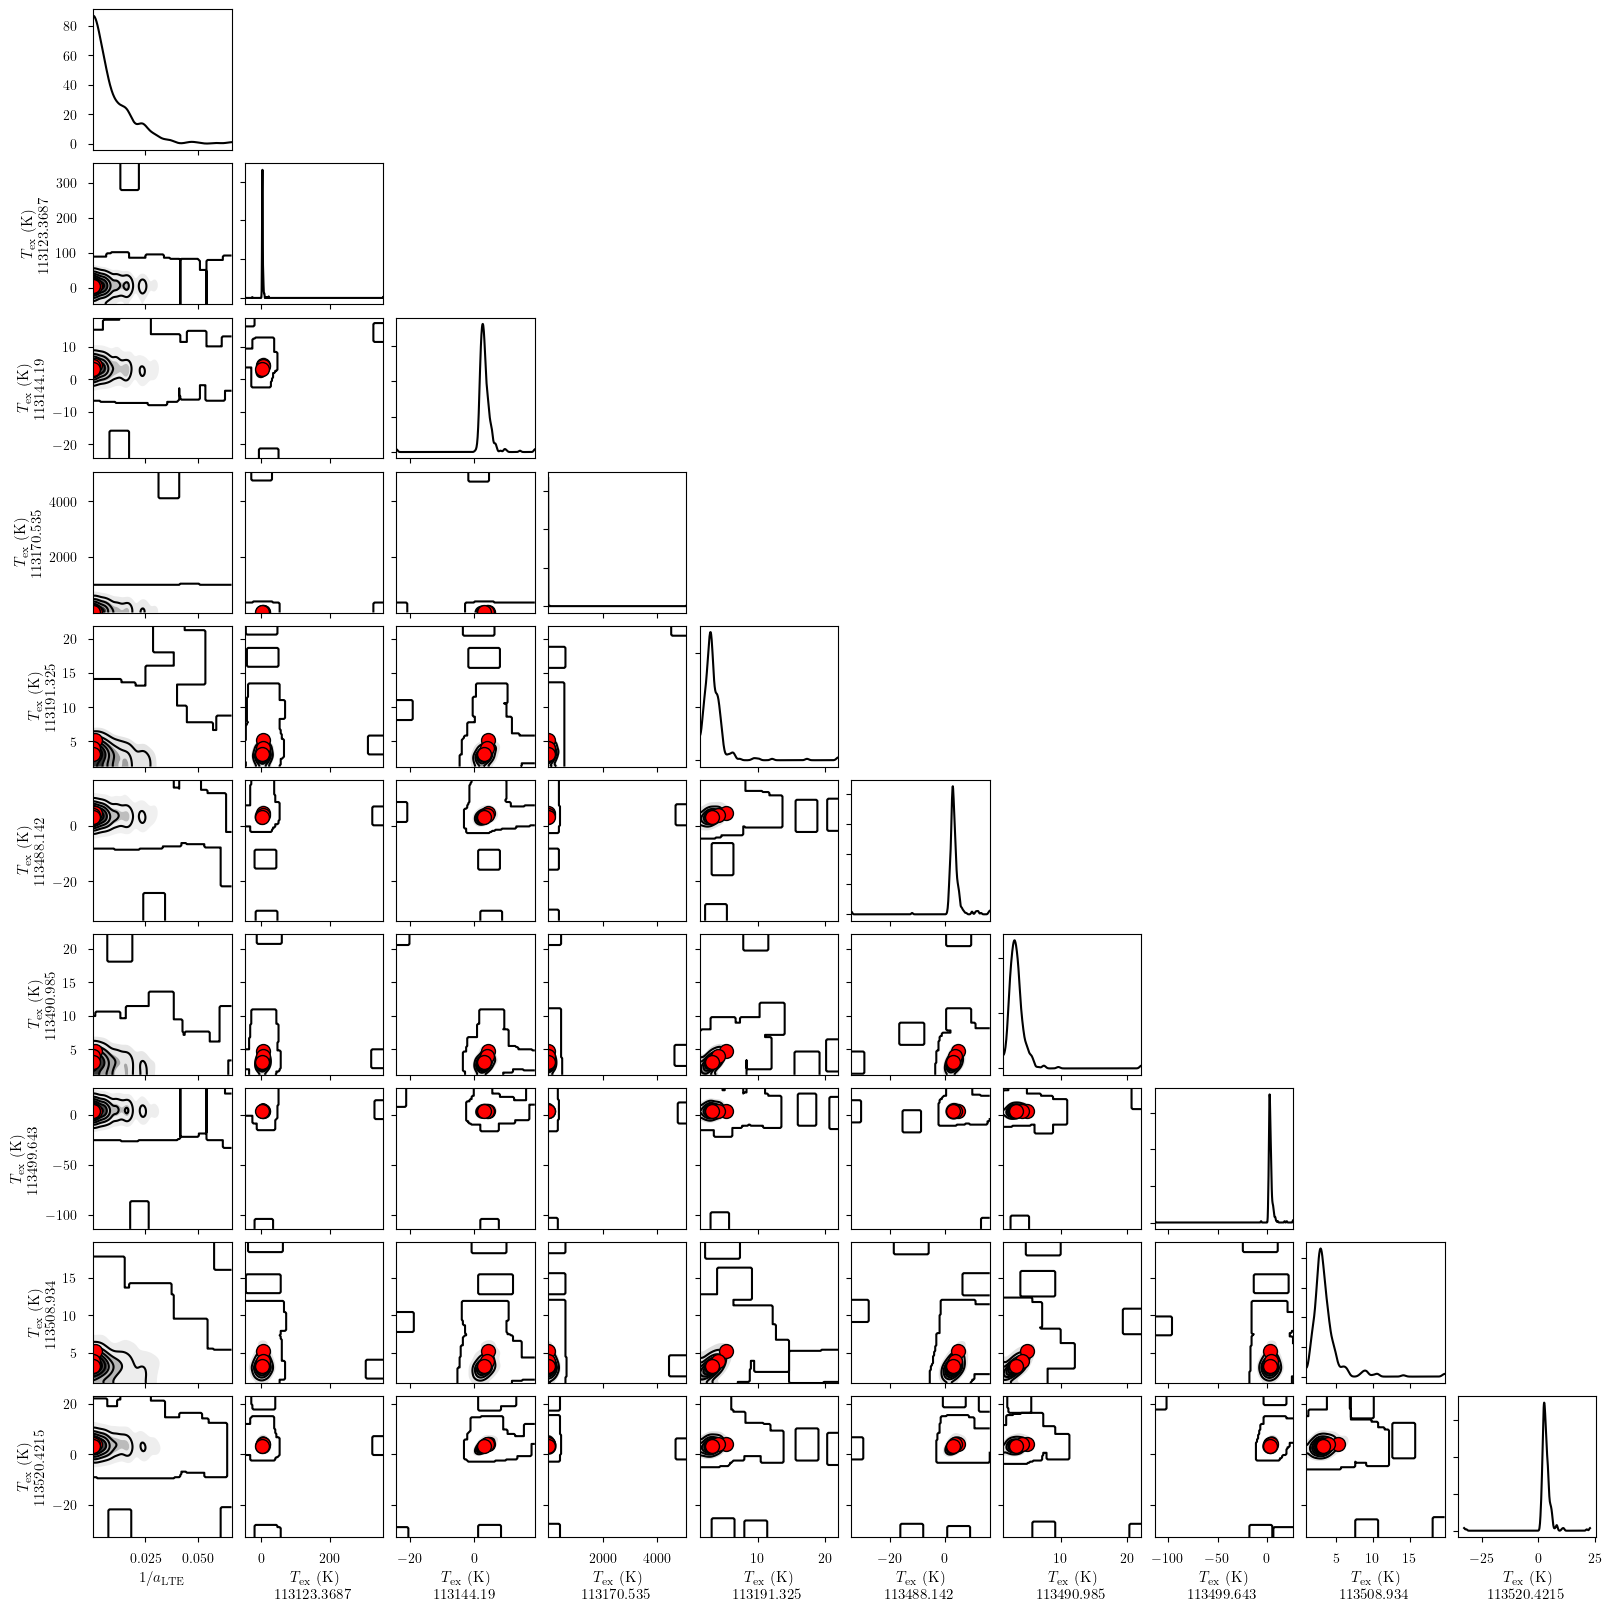

In [7]:
axes = plot_pair(
    prior.prior, # samples
    ['LTE_precision', 'Tex'], # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=sim_params, # truths
)
axes.ravel()[0].figure.set_size_inches(16, 16)

## Variational Inference

In [8]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 0.02, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 6100
Interrupted at 6,099 [6%]: Average Loss = 6.6446e+12


Output()

Runtime: 0.24 minutes


Sampling: [12CN-1, 12CN-2]


Output()

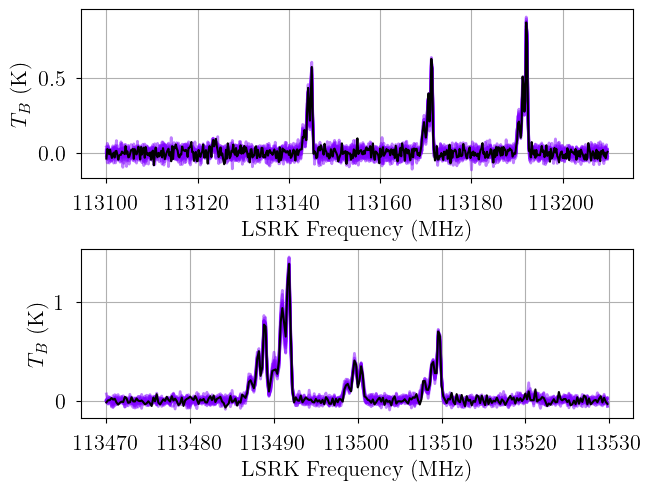

In [9]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## MCMC

In [10]:
start = time.time()
init_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 0.02,
}
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = init_kwargs, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 6100
Interrupted at 6,099 [6%]: Average Loss = 6.6446e+12
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, velocity_norm, log10_Tkin_norm, fwhm_nonthermal_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 215 seconds.


Adding log-likelihood to trace


Output()

There were 183 divergences in converged chains.
Runtime: 4.02 minutes


In [11]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


Sampling: [12CN-1, 12CN-2]


Output()

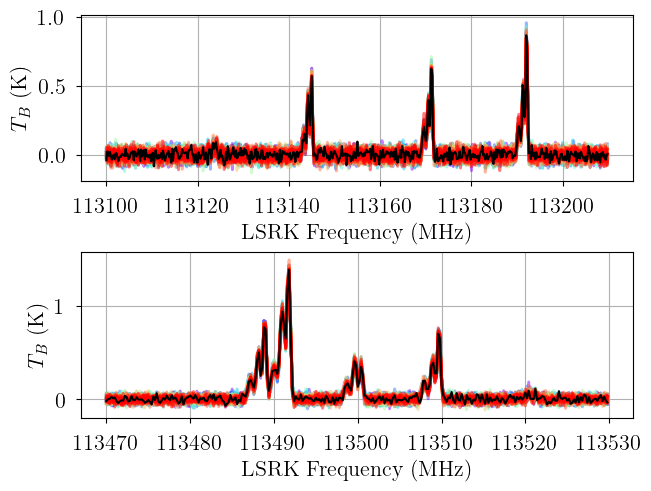

In [12]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [13]:
print("solutions:", model.solutions)

pm.summary(model.trace.solution_0)

solutions: [0]


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
baseline_12CN-1_norm[0]  -0.176  0.044  -0.256   -0.089      0.000    0.001   
baseline_12CN-2_norm[0]  -0.315  0.063  -0.439   -0.201      0.001    0.001   
velocity_norm[0]         -0.004  0.005  -0.014    0.007      0.000    0.000   
velocity_norm[1]          0.837  0.015   0.810    0.865      0.000    0.000   
velocity_norm[2]         -0.663  0.003  -0.669   -0.657      0.000    0.000   
log10_Tkin_norm[0]        0.034  1.031  -1.953    1.970      0.012    0.015   
log10_Tkin_norm[1]        0.025  1.014  -1.808    1.987      0.010    0.013   
log10_Tkin_norm[2]        0.066  1.028  -1.936    1.990      0.015    0.015   
log10_N_norm[0]           0.280  0.065   0.168    0.411      0.002    0.001   
log10_N_norm[1]           0.388  0.165   0.068    0.705      0.006    0.006   
log10_N_norm[2]           0.250  0.059   0.135    0.357      0.001    0.001   
log10_Tex_ul_norm[0]      1.292  0.247   0.808    1.724      0.006    0.006   
log10_Tex_ul_norm[1]      0.134  0.303  -0.274    0.646      0.013    0.028   
log10_Tex_ul_norm[2]      1.742  0.447   0.917    2.615      0.007    0.006   
fwhm_nonthermal_norm[0]   1.308  0.067   1.189    1.429      0.001    0.002   
fwhm_nonthermal_norm[1]   1.615  0.146   1.337    1.886      0.003    0.002   
fwhm_nonthermal_norm[2]   0.992  0.047   0.913    1.074      0.001    0.002   
LTE_precision[0]          0.000  0.000   0.000    0.001      0.000    0.000   
LTE_precision[1]          0.000  0.001   0.000    0.001      0.000    0.000   
LTE_precision[2]          0.003  0.003   0.000    0.008      0.000    0.000   
weights[0, 0 0 1 1]       0.183  0.007   0.172    0.197      0.000    0.000   
weights[0, 0 0 1 2]       0.362  0.011   0.342    0.383      0.000    0.000   
weights[0, 1 0 1 1]       0.051  0.003   0.046    0.055      0.000    0.000   
weights[0, 1 0 1 2]       0.100  0.005   0.091    0.108      0.000    0.000   
weights[0, 1 0 2 1]       0.051  0.002   0.046    0.055      0.000    0.000   
weights[0, 1 0 2 2]       0.101  0.005   0.092    0.109      0.000    0.000   
weights[0, 1 0 2 3]       0.153  0.004   0.146    0.160      0.000    0.000   
weights[1, 0 0 1 1]       0.211  0.010   0.193    0.224      0.000    0.001   
weights[1, 0 0 1 2]       0.428  0.015   0.403    0.448      0.001    0.001   
weights[1, 1 0 1 1]       0.039  0.003   0.034    0.044      0.000    0.000   
weights[1, 1 0 1 2]       0.082  0.007   0.073    0.094      0.000    0.001   
weights[1, 1 0 2 1]       0.040  0.003   0.035    0.045      0.000    0.000   
weights[1, 1 0 2 2]       0.081  0.007   0.072    0.092      0.000    0.001   
weights[1, 1 0 2 3]       0.120  0.005   0.113    0.129      0.000    0.000   
weights[2, 0 0 1 1]       0.177  0.007   0.163    0.189      0.000    0.000   
weights[2, 0 0 1 2]       0.321  0.015   0.294    0.348      0.000    0.000   
weights[2, 1 0 1 1]       0.052  0.003   0.047    0.057      0.000    0.000   
weights[2, 1 0 1 2]       0.122  0.007   0.110    0.135      0.000    0.000   
weights[2, 1 0 2 1]       0.043  0.002   0.039    0.047      0.000    0.000   
weights[2, 1 0 2 2]       0.124  0.007   0.112    0.137      0.000    0.000   
weights[2, 1 0 2 3]       0.162  0.003   0.157    0.169      0.000    0.000   
velocity[0]              -0.011  0.016  -0.041    0.020      0.000    0.000   
velocity[1]               2.512  0.044   2.429    2.594      0.001    0.001   
velocity[2]              -1.989  0.010  -2.007   -1.971      0.000    0.000   
log10_Tkin[0]             1.017  0.516   0.024    1.985      0.006    0.007   
log10_Tkin[1]             1.013  0.507   0.096    1.994      0.005    0.007   
log10_Tkin[2]             1.033  0.514   0.032    1.995      0.007    0.008   
fwhm_thermal[0]           0.162  0.109   0.025    0.347      0.002    0.004   
fwhm_thermal[1]           0.160  0.105   0.025    0.341      0.001    0.004   
fwhm_thermal[2]           0.164  0.106   0.028    0.354      0.002    0.003  

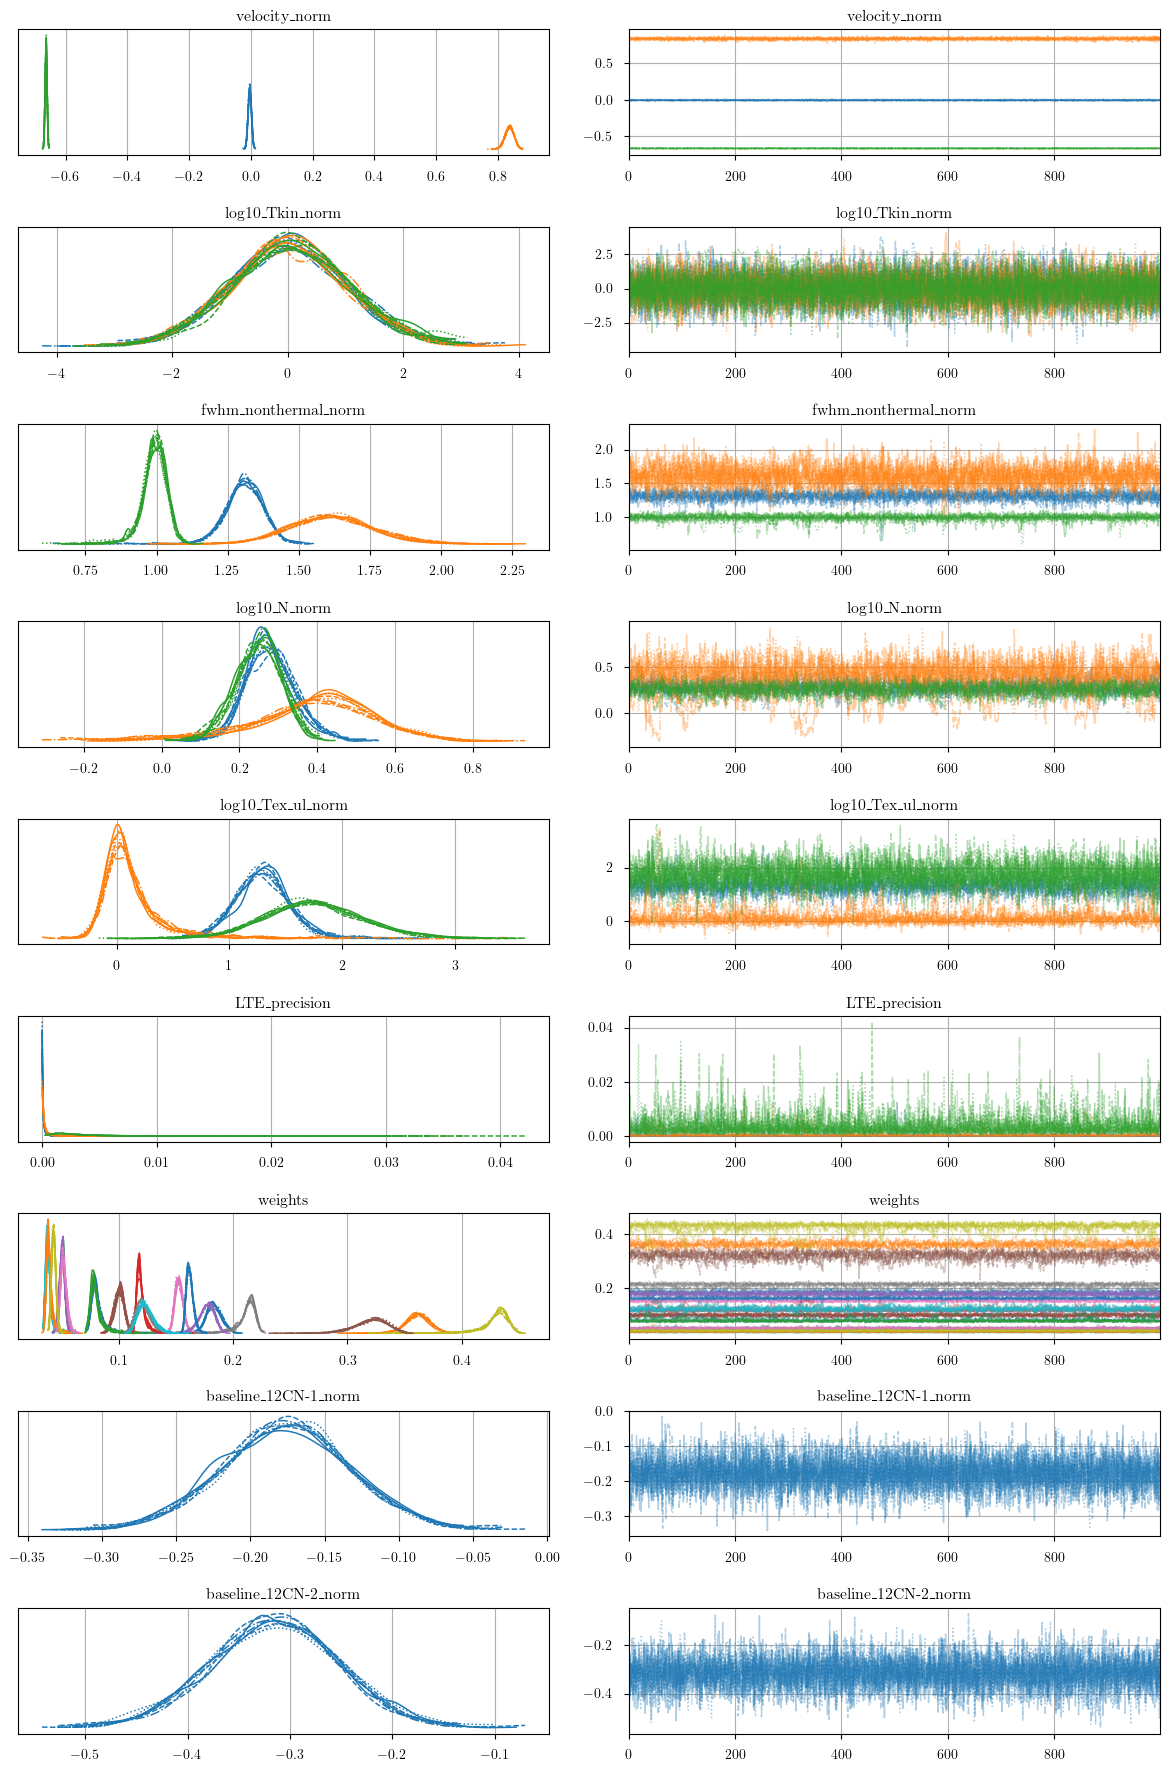

In [14]:
from bayes_spec.plots import plot_traces

axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

['velocity', 'log10_Tkin', 'fwhm_thermal', 'fwhm_nonthermal', 'fwhm', 'log10_N', 'log10_Tex_ul', 'tau_total']


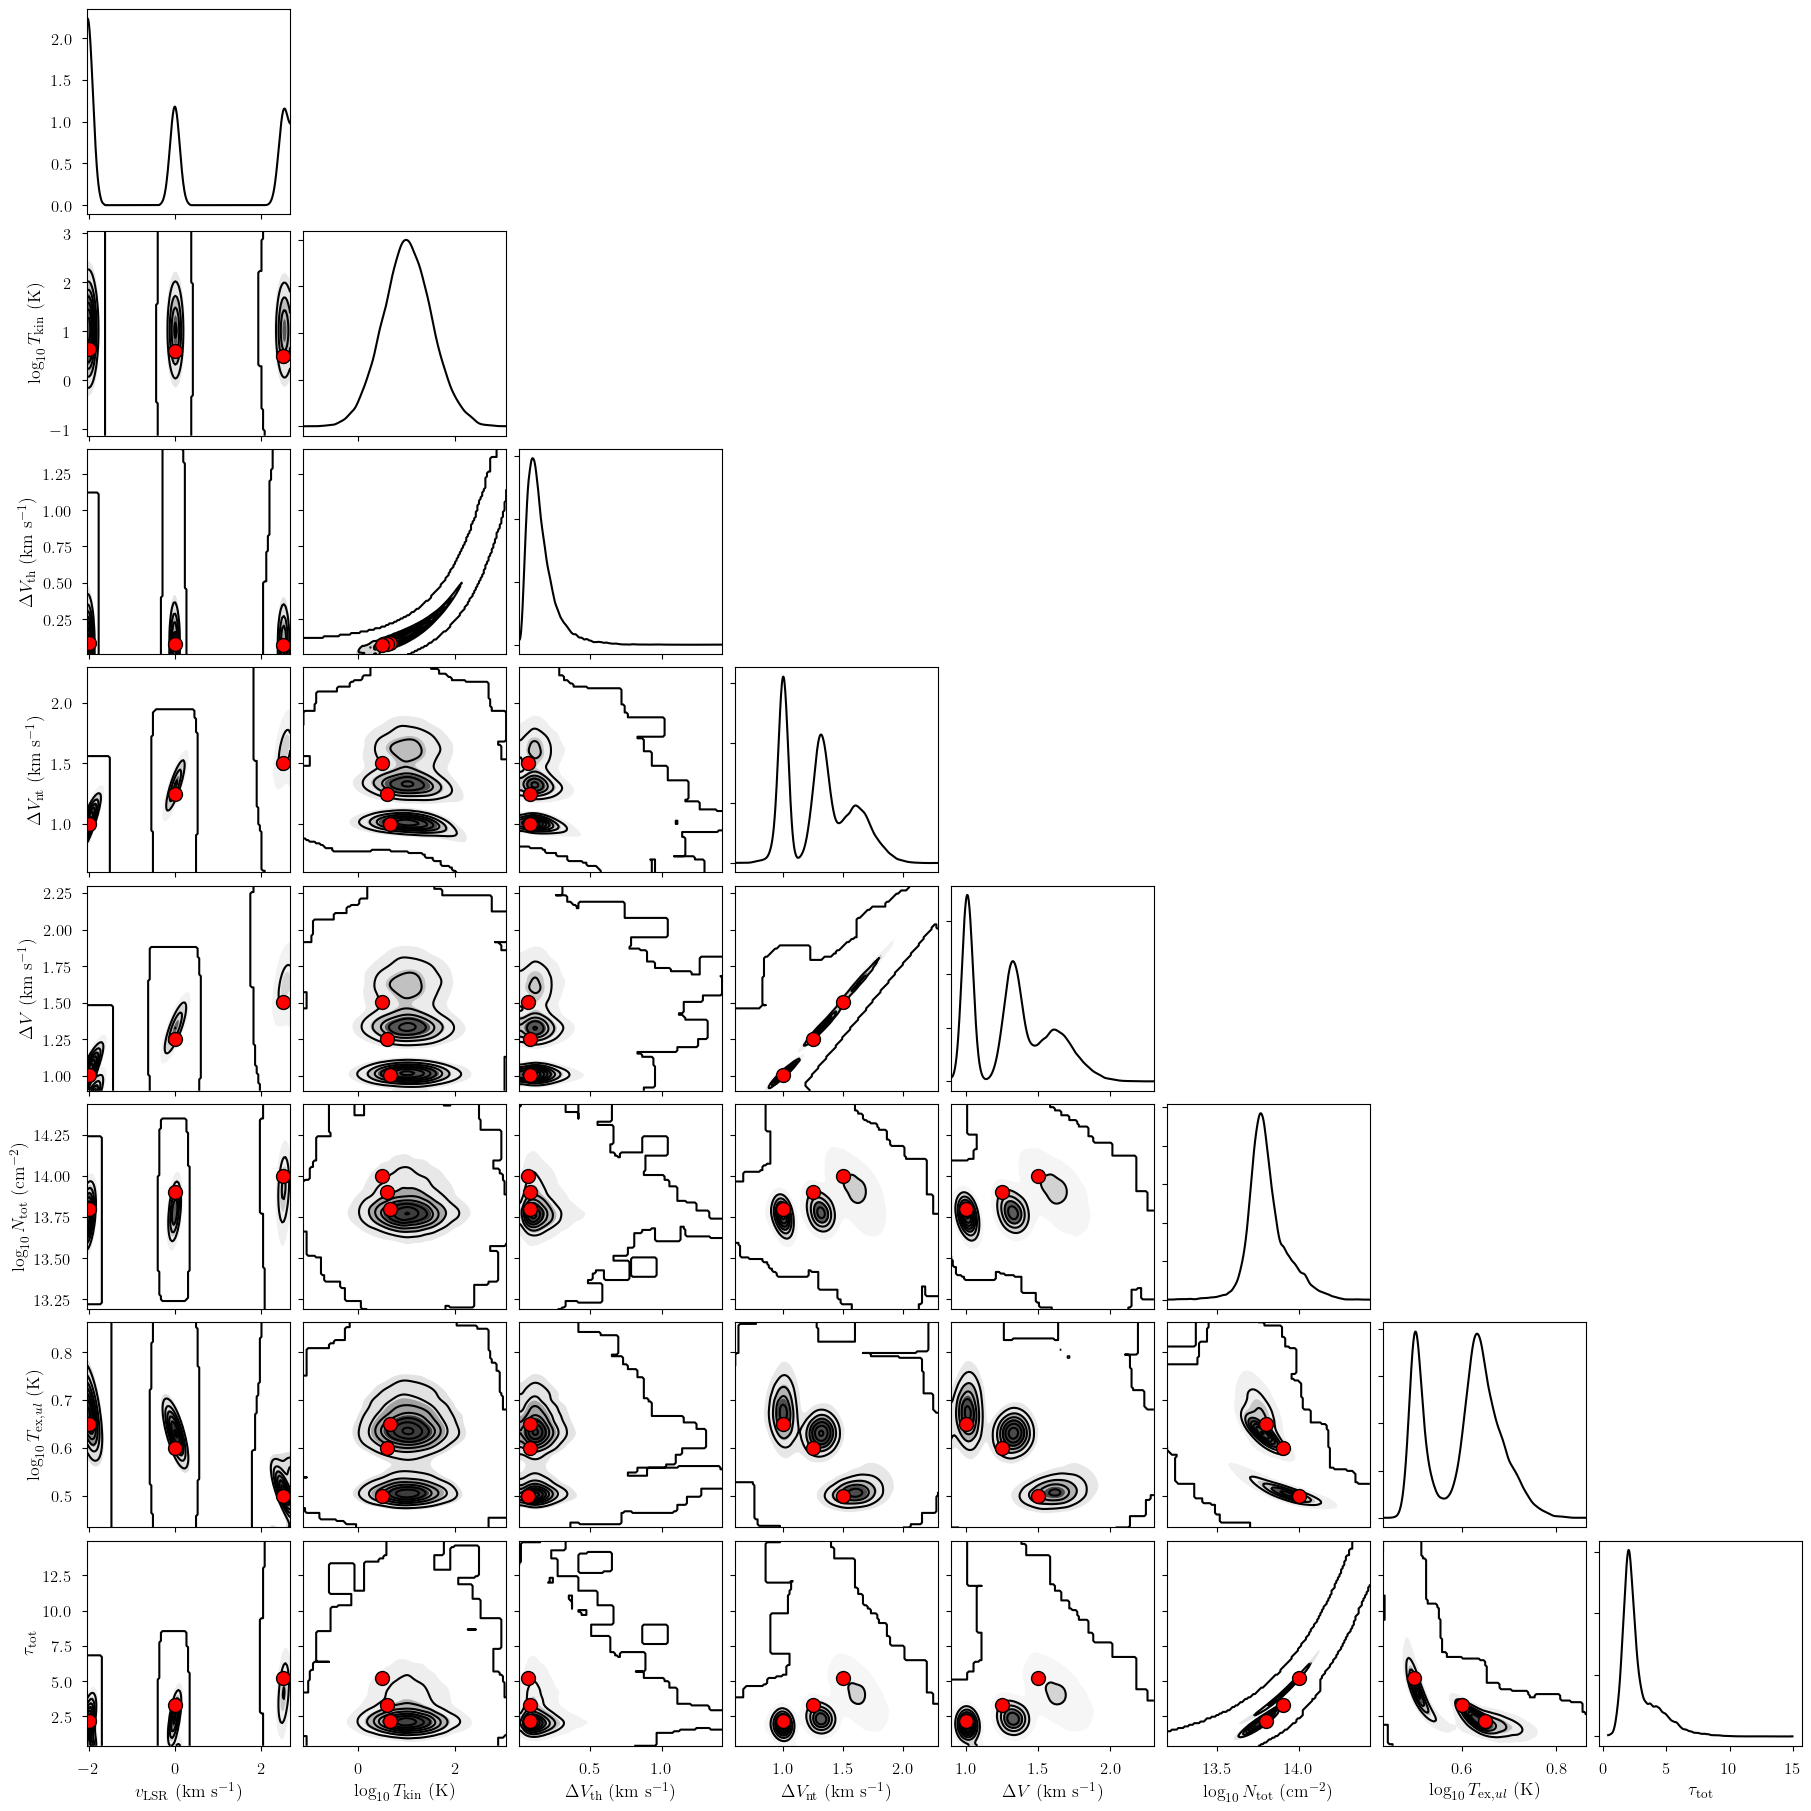

In [15]:
from bayes_spec.plots import plot_pair

var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=sim_params, # truths
)

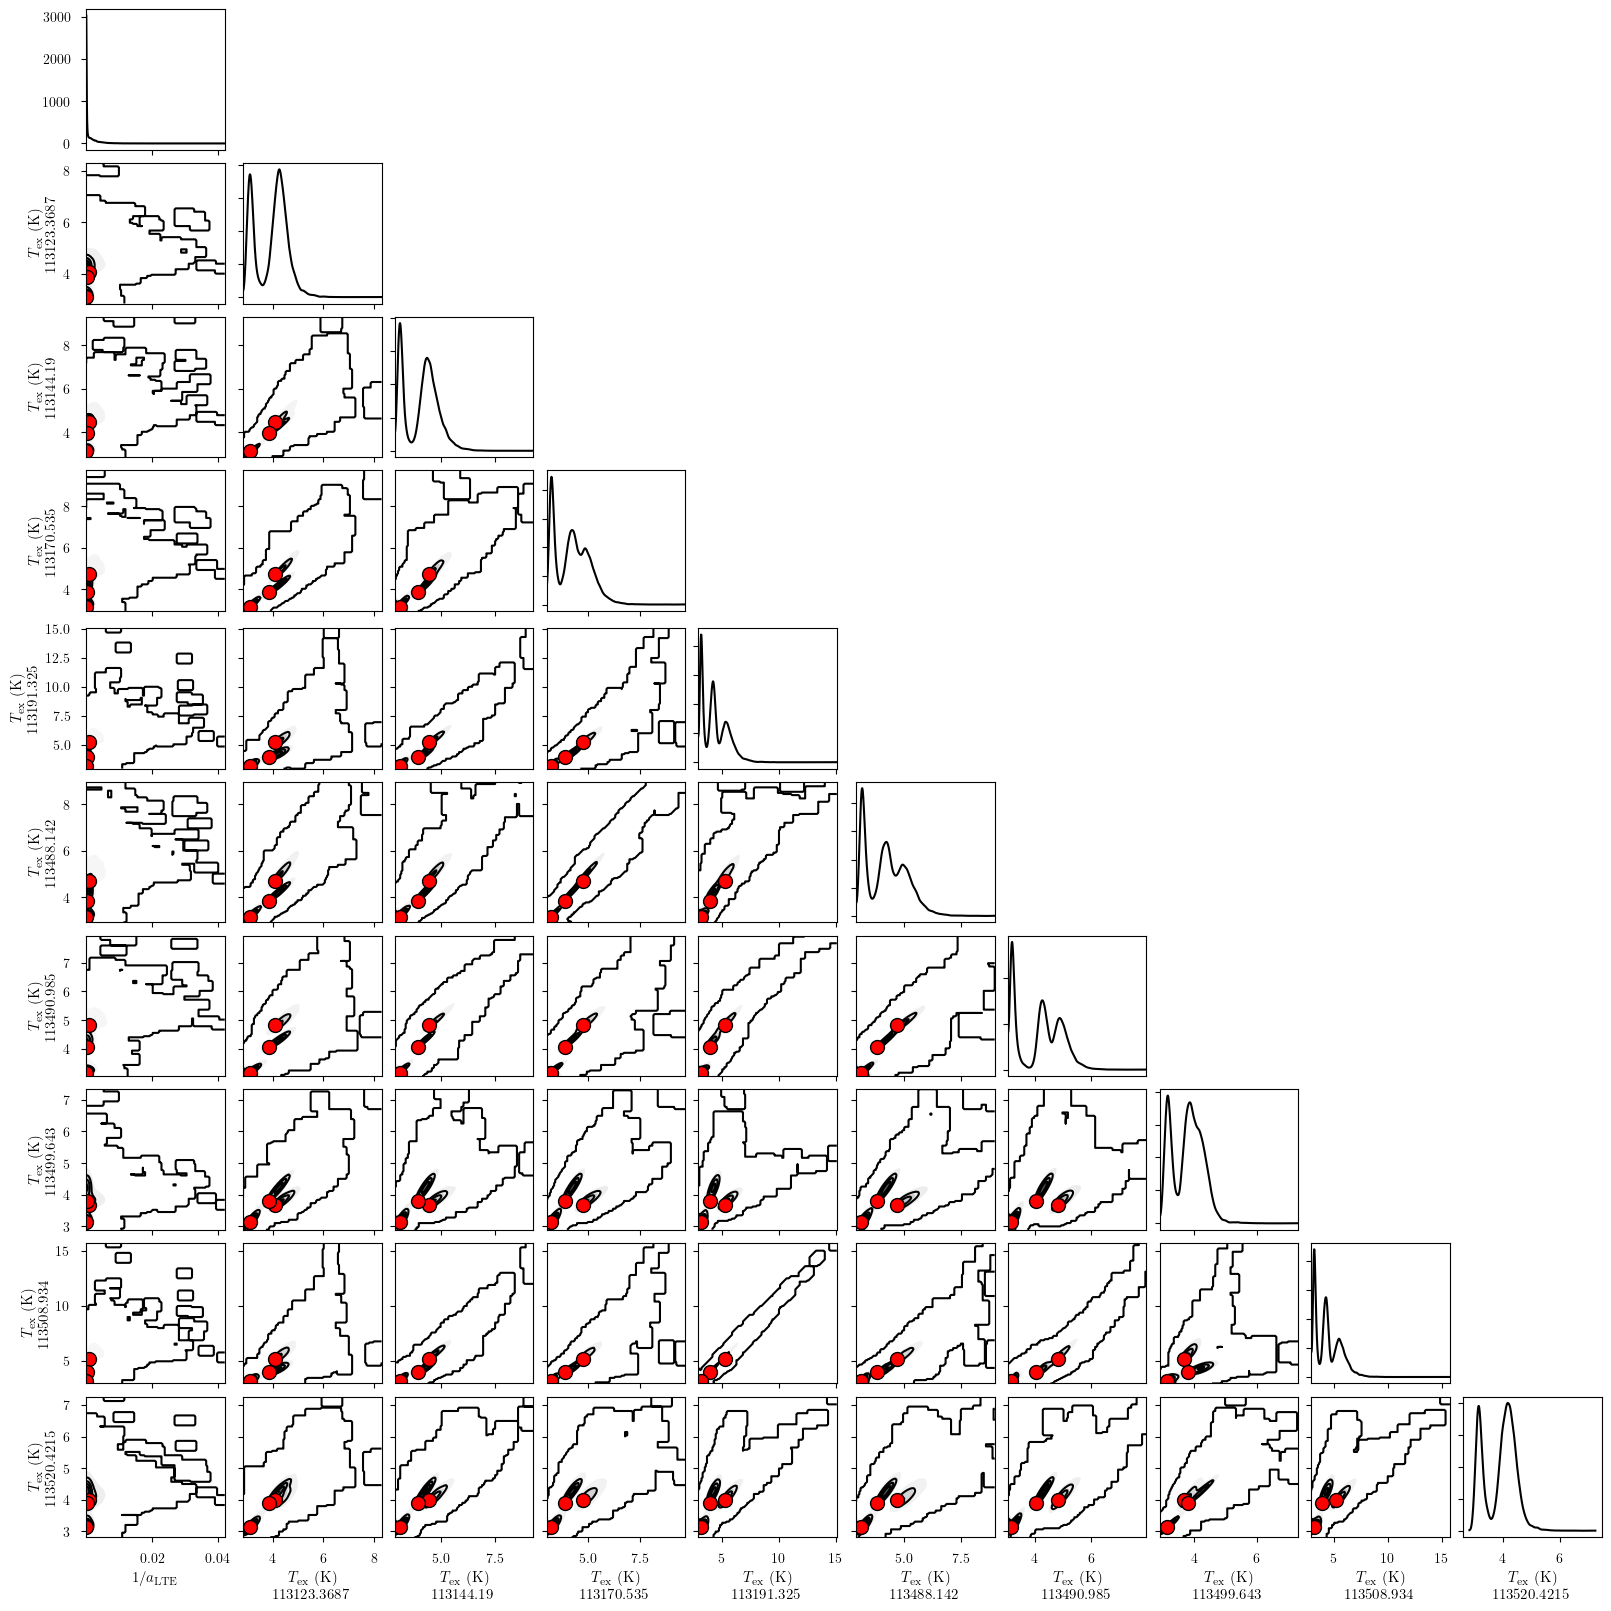

In [16]:
axes = plot_pair(
    model.trace.solution_0, # samples
    ['LTE_precision', 'Tex'], # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=sim_params, # truths
)
axes.ravel()[0].figure.set_size_inches(16, 16)

In [17]:
# identify simulation cloud corresponding to each posterior cloud
sim_cloud_map = {}
for i in range(n_clouds):
    posterior_velocity = model.trace.solution_0['velocity'].sel(cloud=i).data.mean()
    match = np.argmin(np.abs(sim_params["velocity"] - posterior_velocity))
    sim_cloud_map[i] = match
sim_cloud_map

{0: np.int64(1), 1: np.int64(2), 2: np.int64(0)}

['velocity', 'log10_Tkin', 'fwhm_thermal', 'fwhm_nonthermal', 'fwhm', 'log10_N', 'log10_Tex_ul', 'tau_total']


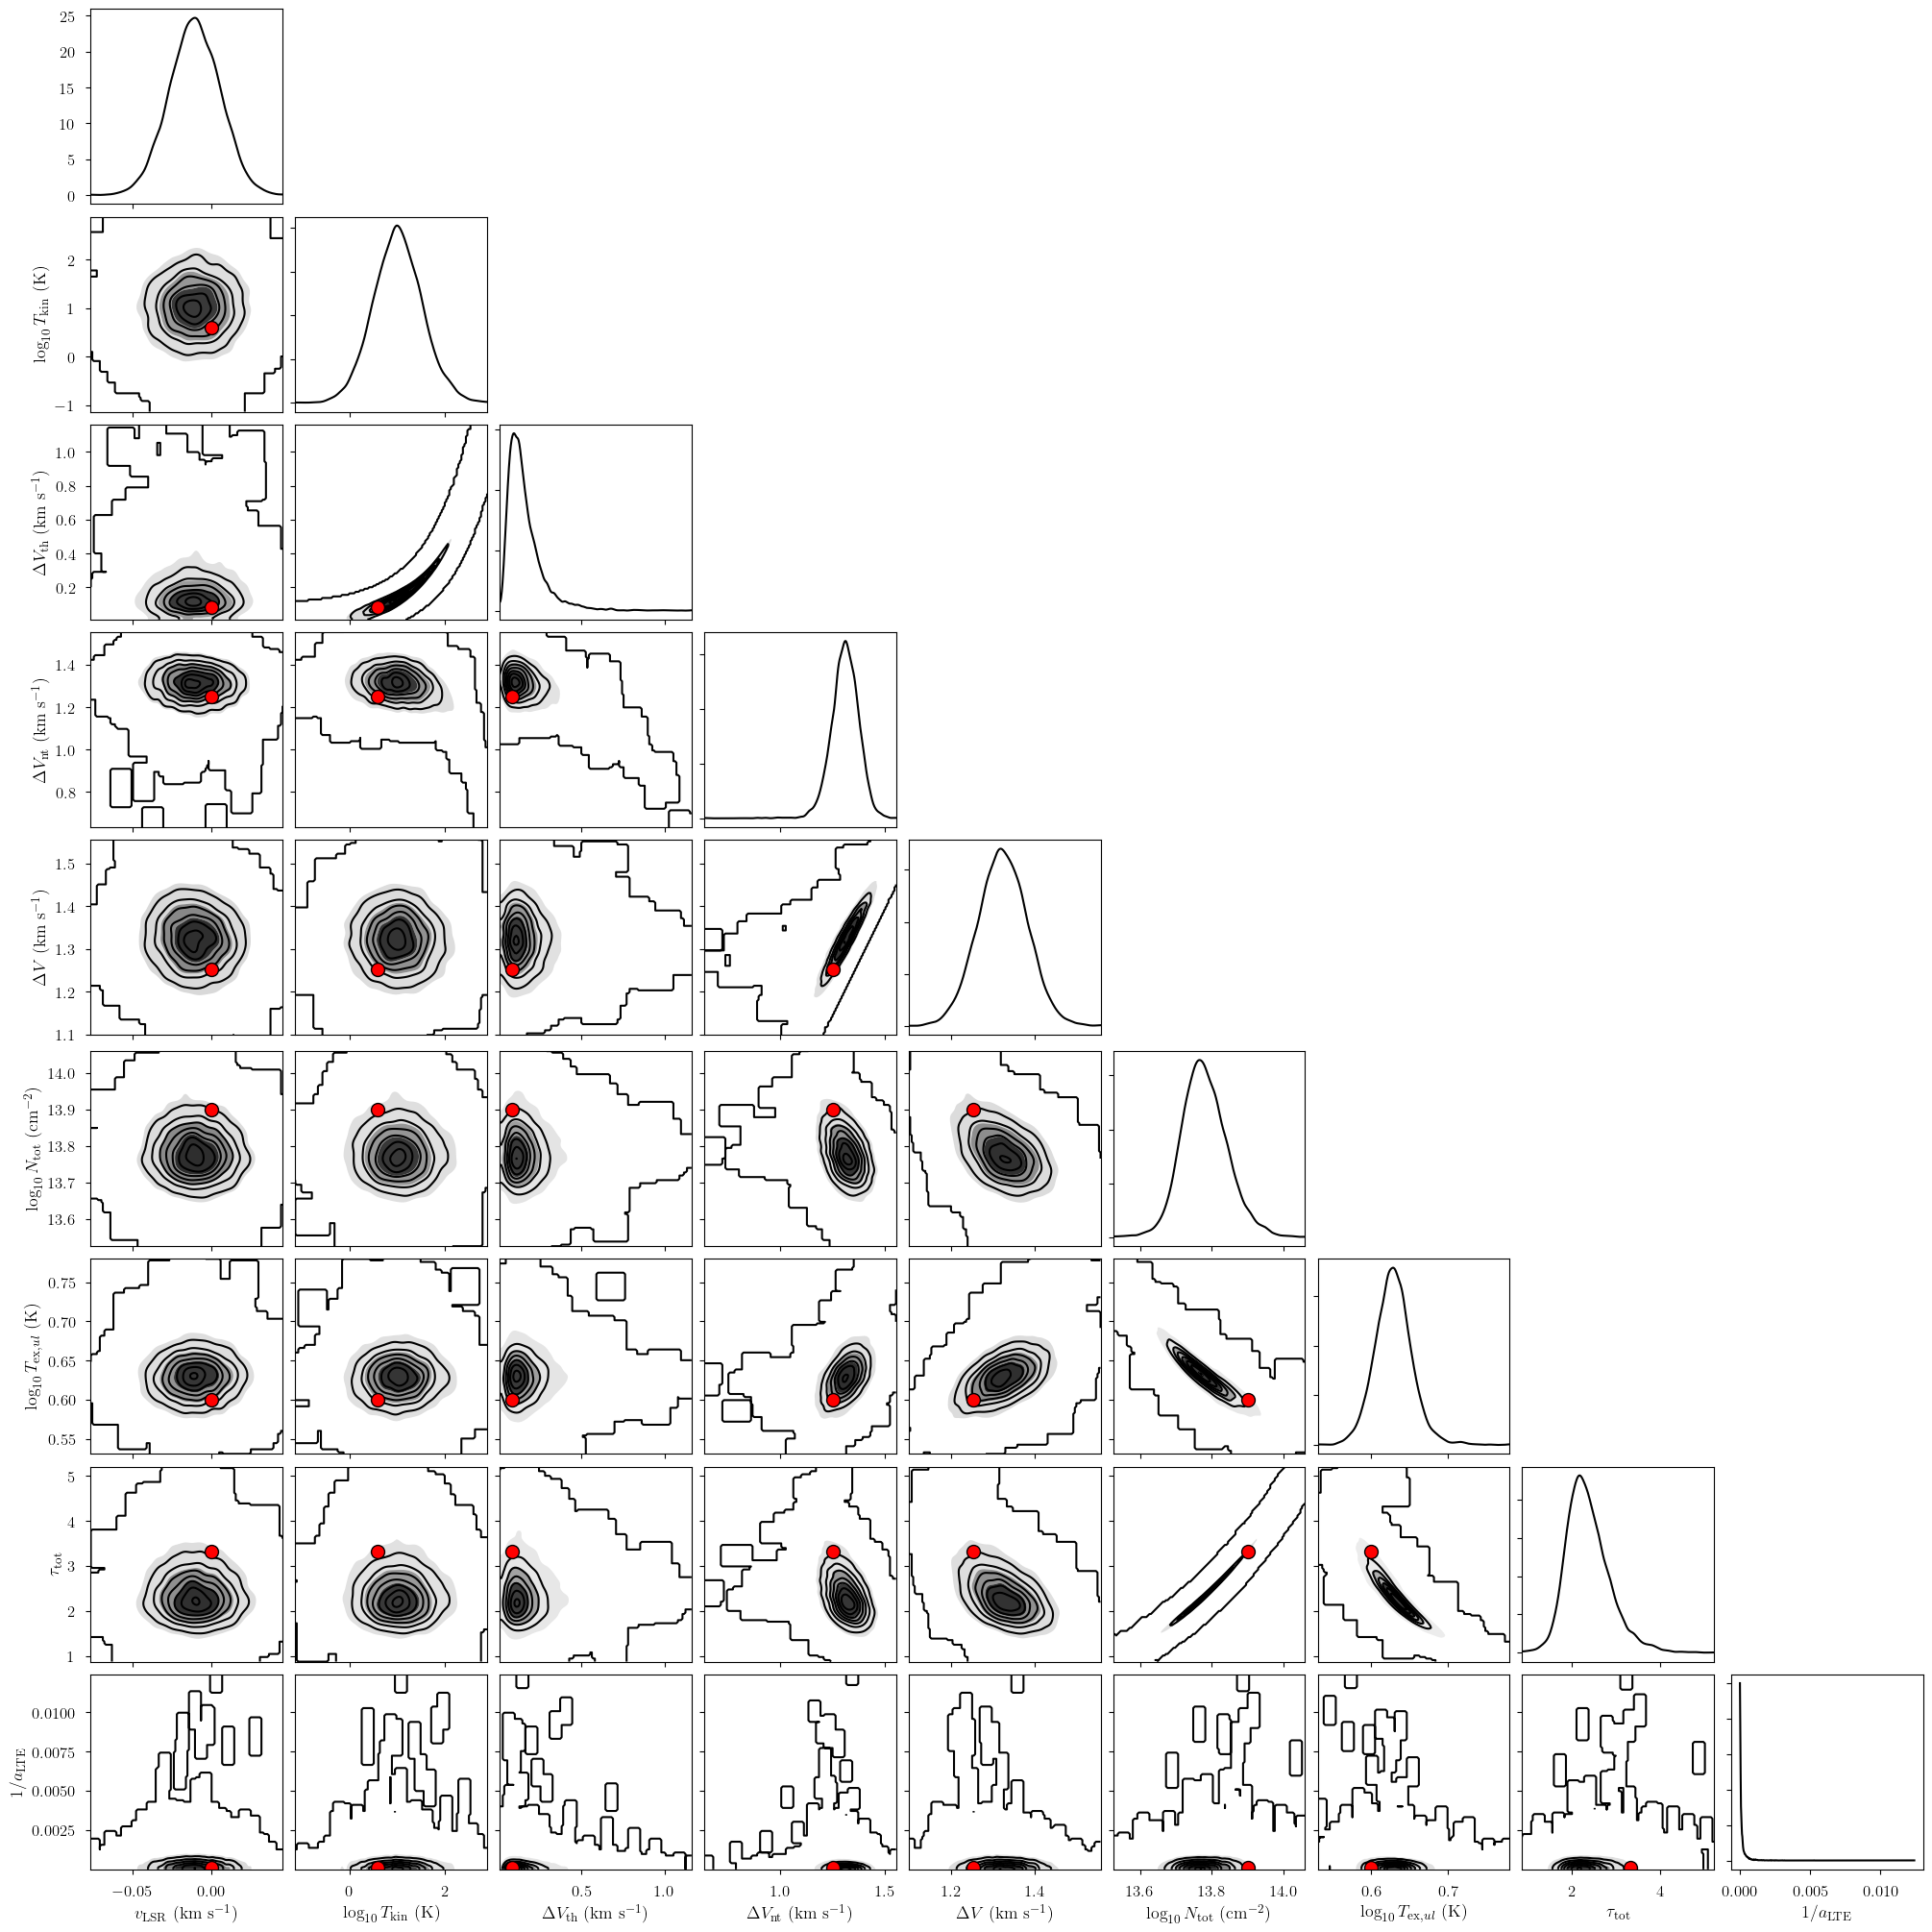

In [18]:
cloud = 0

# subset of sim_params
my_sim_params = {}
for var_name in model.cloud_deterministics + ['LTE_precision']:
    my_sim_params[var_name] = sim_params[var_name][sim_cloud_map[cloud]]
for var_name in model.hyper_deterministics:
    my_sim_params[var_name] = sim_params[var_name]

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0.sel(cloud=cloud), # samples
    var_names + model.hyper_deterministics + ["LTE_precision"], # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=my_sim_params, # truths
)

['velocity', 'log10_Tkin', 'fwhm_thermal', 'fwhm_nonthermal', 'fwhm', 'log10_N', 'log10_Tex_ul', 'tau_total']


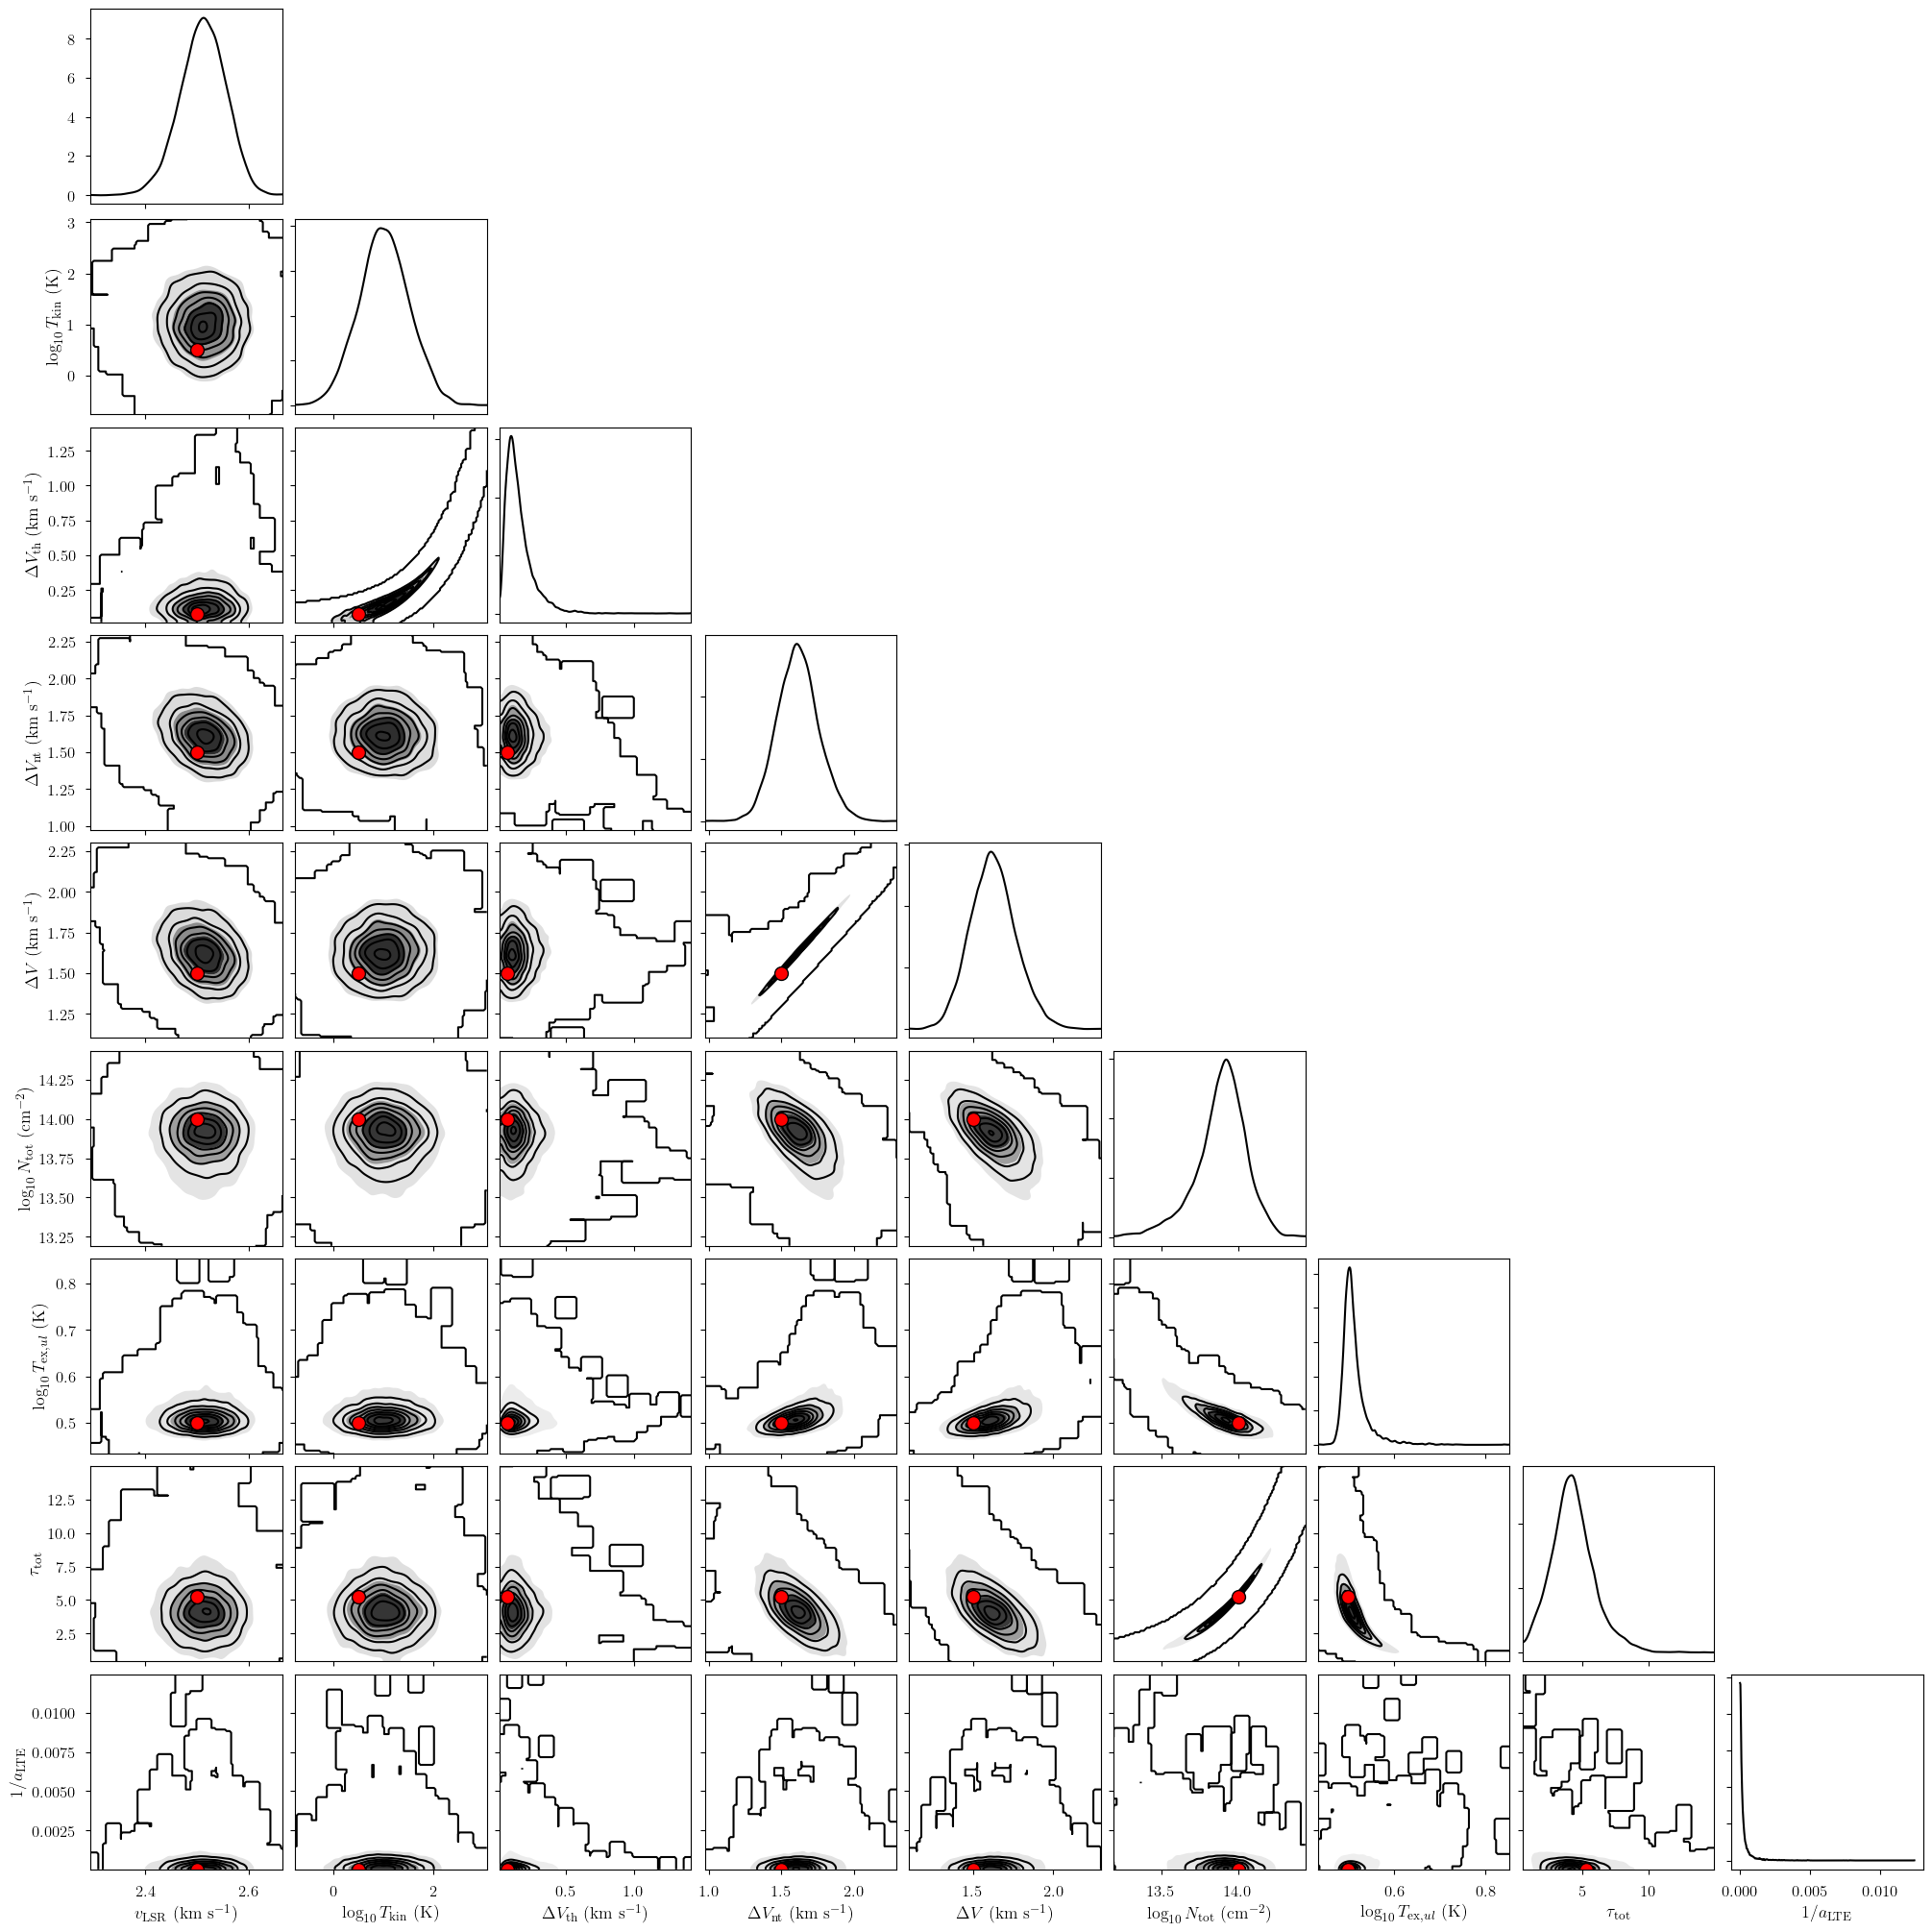

In [19]:
cloud = 1

# subset of sim_params
my_sim_params = {}
for var_name in model.cloud_deterministics + ['LTE_precision']:
    my_sim_params[var_name] = sim_params[var_name][sim_cloud_map[cloud]]
for var_name in model.hyper_deterministics:
    my_sim_params[var_name] = sim_params[var_name]

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0.sel(cloud=cloud), # samples
    var_names + model.hyper_deterministics + ["LTE_precision"], # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=my_sim_params, # truths
)

['velocity', 'log10_Tkin', 'fwhm_thermal', 'fwhm_nonthermal', 'fwhm', 'log10_N', 'log10_Tex_ul', 'tau_total']


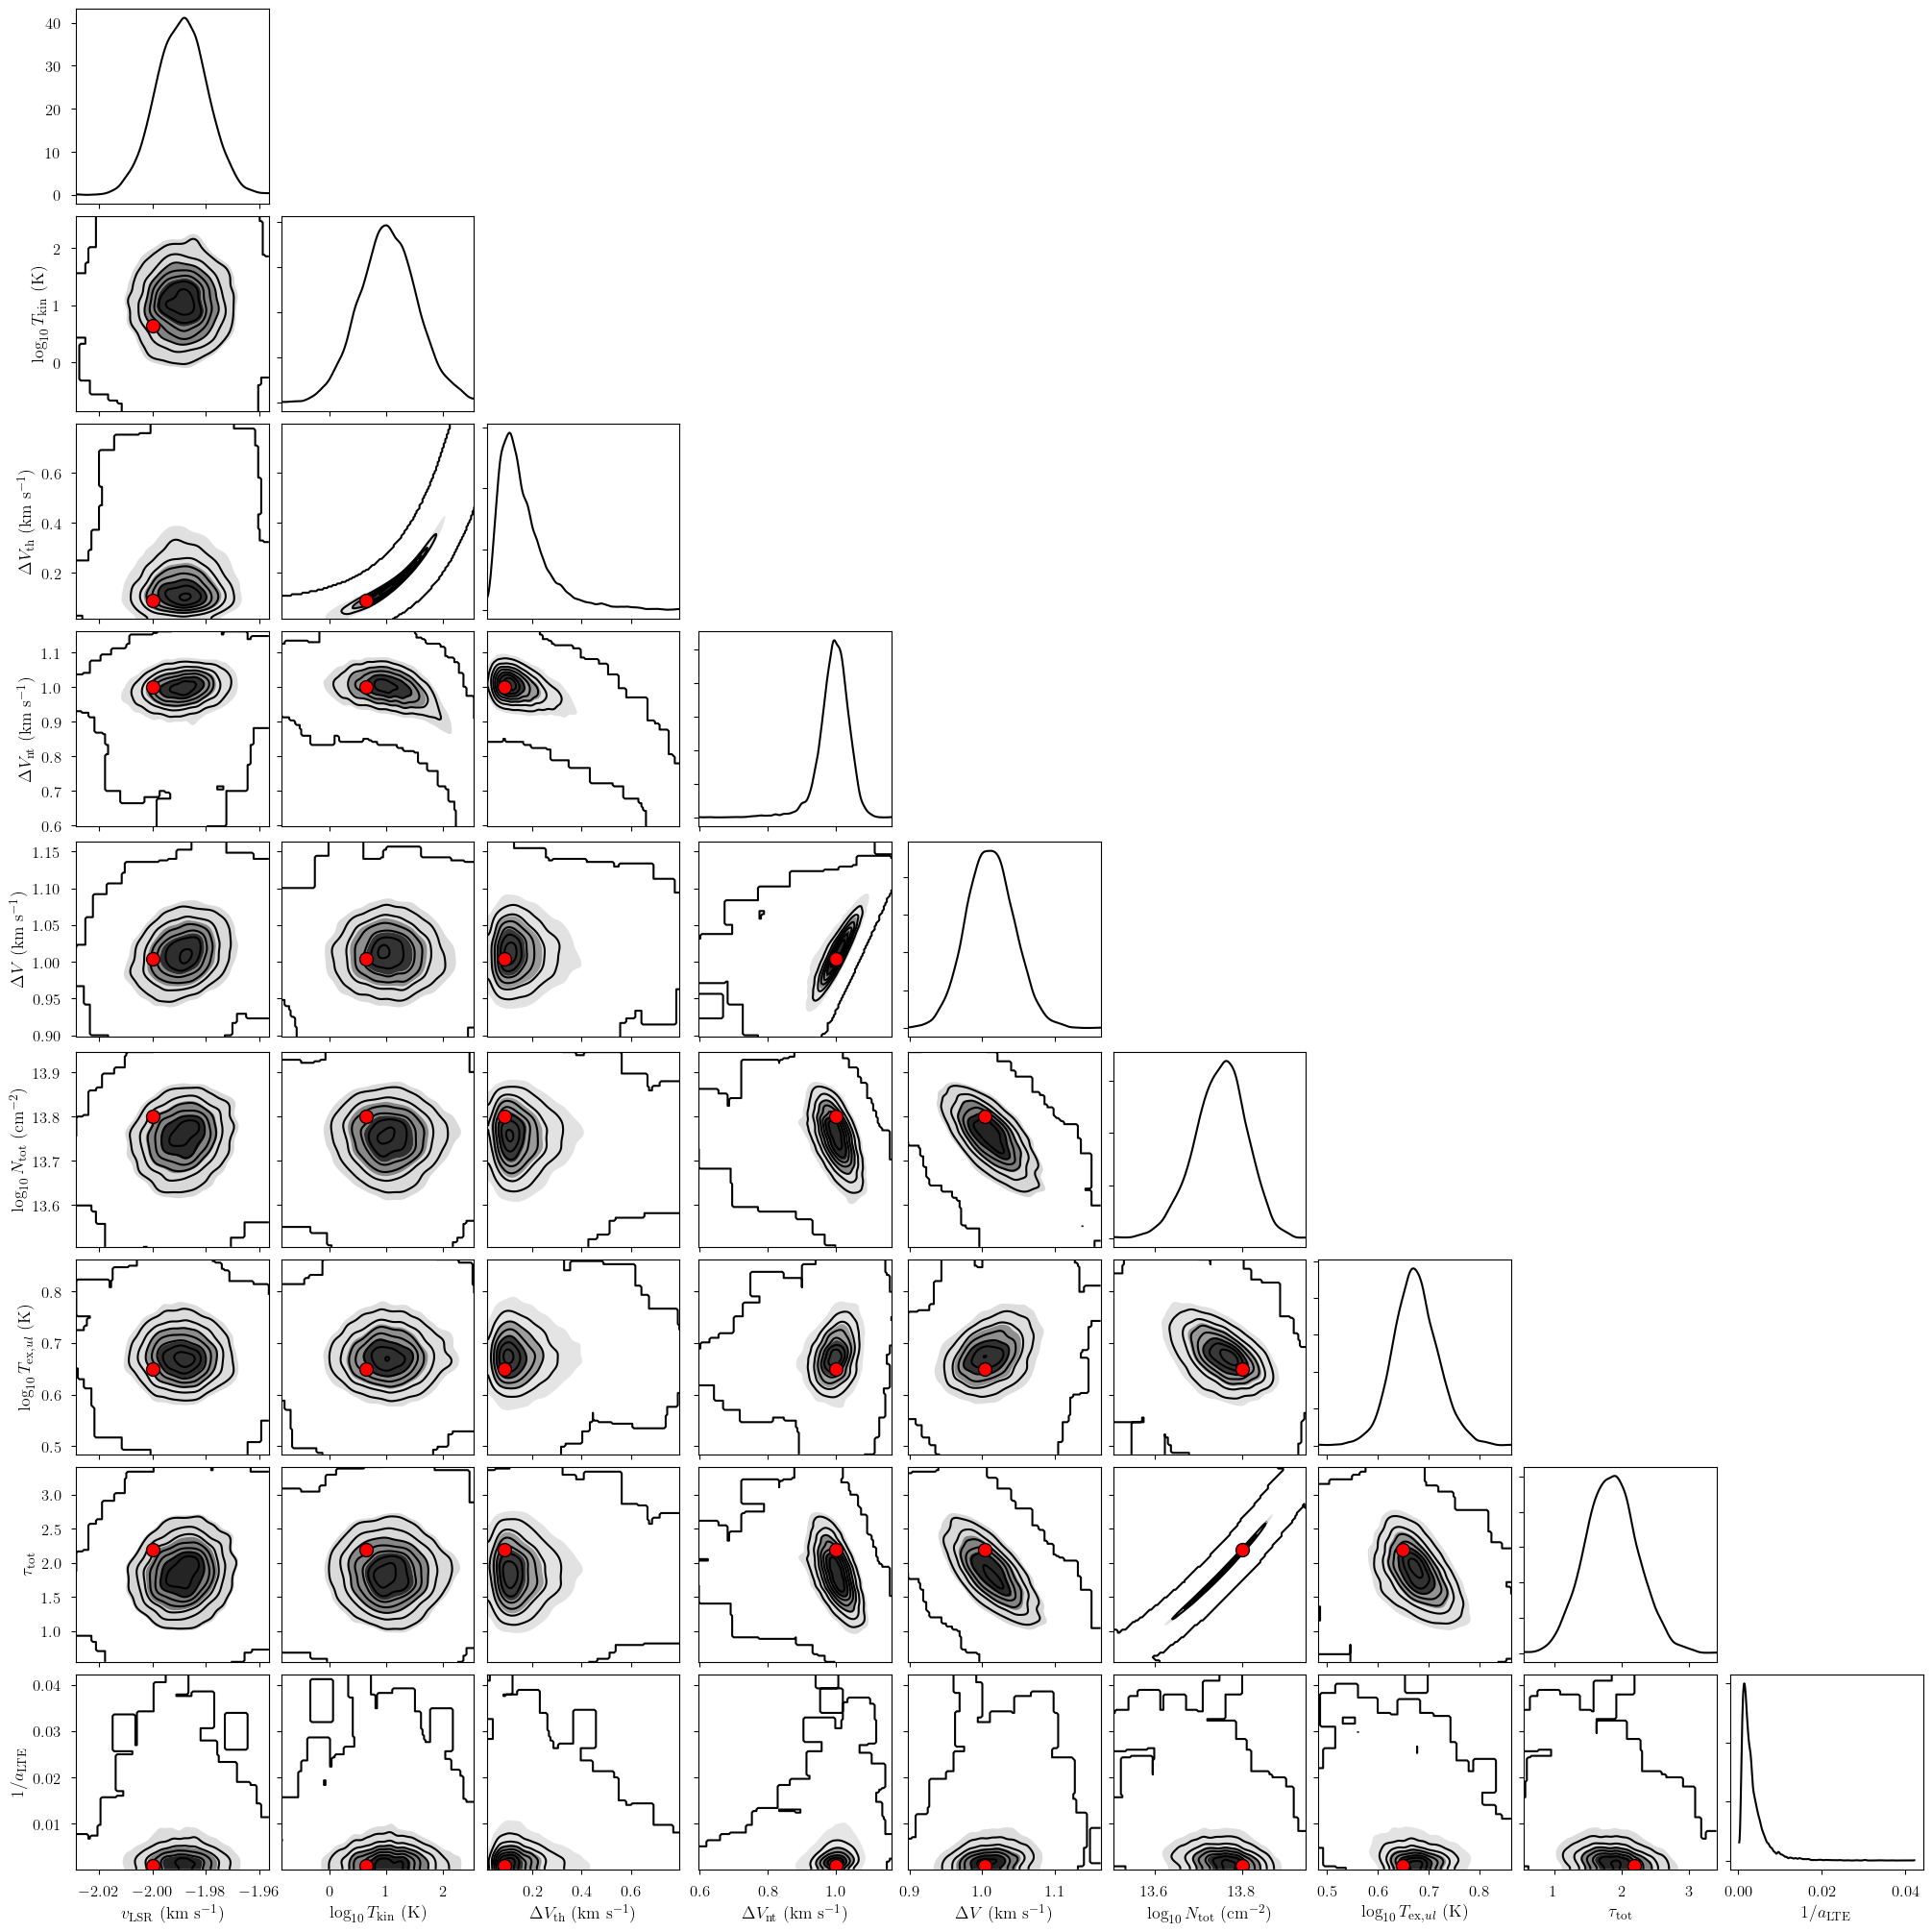

In [20]:
cloud = 2

# subset of sim_params
my_sim_params = {}
for var_name in model.cloud_deterministics + ['LTE_precision']:
    my_sim_params[var_name] = sim_params[var_name][sim_cloud_map[cloud]]
for var_name in model.hyper_deterministics:
    my_sim_params[var_name] = sim_params[var_name]

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0.sel(cloud=cloud), # samples
    var_names + model.hyper_deterministics + ["LTE_precision"], # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=my_sim_params, # truths
)

In [21]:
var_names=model.cloud_deterministics + model.baseline_freeRVs + model.hyper_deterministics + ["LTE_precision"]
point_stats = az.summary(model.trace.solution_0, var_names=var_names, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -3337.0410156336734


mean     sd  hdi_16%  hdi_84%
velocity[0]              -0.011  0.016   -0.027    0.005
velocity[1]               2.512  0.044    2.472    2.559
velocity[2]              -1.989  0.010   -1.999   -1.980
log10_Tkin[0]             1.017  0.516    0.490    1.491
log10_Tkin[1]             1.013  0.507    0.516    1.510
log10_Tkin[2]             1.033  0.514    0.560    1.578
fwhm_thermal[0]           0.162  0.109    0.048    0.188
fwhm_thermal[1]           0.160  0.105    0.049    0.187
fwhm_thermal[2]           0.164  0.106    0.045    0.189
fwhm_nonthermal[0]        1.308  0.067    1.252    1.376
fwhm_nonthermal[1]        1.615  0.146    1.467    1.748
fwhm_nonthermal[2]        0.992  0.047    0.963    1.039
fwhm[0]                   1.323  0.059    1.265    1.381
fwhm[1]                   1.627  0.143    1.470    1.749
fwhm[2]                   1.011  0.033    0.979    1.044
log10_N[0]               13.780  0.065   13.715   13.837
log10_N[1]               13.888  0.165   13.768   14.053
log10_N[2]               13.750  0.059   13.696   13.812
log10_Tex_ul[0]           0.629  0.025    0.608    0.653
log10_Tex_ul[1]           0.513  0.030    0.488    0.522
log10_Tex_ul[2]           0.674  0.045    0.626    0.711
Tex[113123.3687, 0]       4.238  0.291    3.955    4.479
Tex[113123.3687, 1]       3.210  0.300    2.980    3.255
Tex[113123.3687, 2]       4.457  0.342    4.056    4.637
Tex[113144.19, 0]         4.283  0.277    3.996    4.483
Tex[113144.19, 1]         3.177  0.231    2.976    3.229
Tex[113144.19, 2]         4.861  0.457    4.344    5.070
Tex[113170.535, 0]        4.210  0.272    3.956    4.459
Tex[113170.535, 1]        3.338  0.366    3.075    3.363
Tex[113170.535, 2]        5.121  0.471    4.591    5.352
Tex[113191.325, 0]        4.254  0.261    4.009    4.474
Tex[113191.325, 1]        3.301  0.287    3.075    3.343
Tex[113191.325, 2]        5.667  0.673    4.949    5.968
Tex[113488.142, 0]        4.229  0.270    3.975    4.464
Tex[113488.142, 1]        3.308  0.334    3.054    3.332
Tex[113488.142, 2]        5.224  0.490    4.674    5.470
Tex[113490.985, 0]        4.310  0.187    4.115    4.448
Tex[113490.985, 1]        3.252  0.169    3.115    3.272
Tex[113490.985, 2]        5.035  0.307    4.680    5.169
Tex[113499.643, 0]        4.245  0.277    3.960    4.466
Tex[113499.643, 1]        3.270  0.311    3.022    3.304
Tex[113499.643, 2]        3.873  0.206    3.623    3.986
Tex[113508.934, 0]        4.275  0.263    4.007    4.470
Tex[113508.934, 1]        3.273  0.266    3.059    3.322
Tex[113508.934, 2]        5.796  0.719    4.991    6.070
Tex[113520.4215, 0]       4.291  0.274    4.027    4.506
Tex[113520.4215, 1]       3.237  0.255    3.022    3.294
Tex[113520.4215, 2]       4.174  0.294    3.857    4.356
tau[113123.3687, 0]       0.029  0.006    0.021    0.033
tau[113123.3687, 1]       0.052  0.021    0.030    0.067
tau[113123.3687, 2]       0.025  0.005    0.020    0.030
tau[113144.19, 0]         0.232  0.049    0.177    0.263
tau[113144.19, 1]         0.428  0.168    0.254    0.559
tau[113144.19, 2]         0.180  0.039    0.136    0.213
tau[113170.535, 0]        0.232  0.051    0.172    0.261
tau[113170.535, 1]        0.407  0.164    0.234    0.531
tau[113170.535, 2]        0.189  0.040    0.147    0.224
tau[113191.325, 0]        0.295  0.062    0.224    0.333
tau[113191.325, 1]        0.536  0.211    0.317    0.700
tau[113191.325, 2]        0.211  0.049    0.155    0.252
tau[113488.142, 0]        0.302  0.066    0.224    0.340
tau[113488.142, 1]        0.532  0.213    0.304    0.692
tau[113488.142, 2]        0.243  0.051    0.189    0.289
tau[113490.985, 0]        0.781  0.158    0.602    0.881
tau[113490.985, 1]        1.431  0.554    0.854    1.857
tau[113490.985, 2]        0.596  0.122    0.462    0.703
tau[113499.643, 0]        0.238  0.052    0.179    0.270
tau[113499.643, 1]        0.422  0.169    0.242    0.549
tau[113499.643, 2]        0.222  0.041    0.180    0.261
tau[113508.934, 0]        0.228  0.04